In [1]:
import torch, torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchsummary import summary
from torch.utils.data import TensorDataset, DataLoader

from tqdm import tqdm 
import numpy as np
from skimage.transform import resize
from numpy.fft import fftn, fftshift

import matplotlib.pyplot as plt
import matplotlib

import os

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor
from pytorch_lightning.callbacks import ModelCheckpoint

/home/mcherukara/miniconda3/envs/PyTorch1.11/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
plt.style.use('seaborn-white')
#matplotlib.rc('xtick', labelsize=20) 
#matplotlib.rc('ytick', labelsize=20)
matplotlib.rc('font',family='Times New Roman')
matplotlib.rcParams['font.size'] = 20
plt.viridis()

<Figure size 432x288 with 0 Axes>

In [3]:
def plot3(data,titles):
    if(len(titles)<3):
        titles=["Plot1", "Plot2", "Plot3"]
    fig,ax = plt.subplots(1,3, figsize=(20,12))
    im=ax[0].imshow(data[0])
    ax[0].set_title(titles[0])
    ax[0].axis('off')
    plt.colorbar(im,ax=ax[0], fraction=0.046, pad=0.04)
    im=ax[1].imshow(data[1])
    ax[1].set_title(titles[1])
    ax[1].axis('off')
    plt.colorbar(im,ax=ax[1], fraction=0.046, pad=0.04)
    im=ax[2].imshow(data[2])
    ax[2].set_title(titles[2])
    ax[2].axis('off')
    plt.colorbar(im,ax=ax[2], fraction=0.046, pad=0.04)

In [4]:
EPOCHS = 60
NGPUS = torch.cuda.device_count()
BATCH_SIZE = NGPUS * 64
LR = NGPUS * 1e-3
print("GPUs:", NGPUS, "Batch size:", BATCH_SIZE, "Learning rate:", LR)

GPUs: 8 Batch size: 512 Learning rate: 0.008


In [5]:
H,W = 64,64
NLINES = 100 #How many lines of data to use for training?
NLTEST = 60 #How many lines for the test set?

N_VALID = 805 #How much to reserve for validation

In [6]:
path = os.getcwd()

MODEL_SAVE_PATH = path +'/trained_model/'
if (not os.path.isdir(MODEL_SAVE_PATH)):
    os.mkdir(MODEL_SAVE_PATH)

In [7]:
data_diffr = np.load(path+'/../../data/20191008_39_diff.npz')['arr_0']
real_space = np.load(path+'/../../data/20191008_39_amp_pha_10nm_full.npy')
amp = np.abs(real_space)
ph = np.angle(real_space)
amp.shape

(161, 161, 64, 64)

In [8]:
print(data_diffr.shape)
#plt.matshow(np.log10(data_diffr[0,0]))

data_diffr_red = np.zeros((data_diffr.shape[0],data_diffr.shape[1],64,64), float)
for i in tqdm(range(data_diffr.shape[0])):
    for j in range(data_diffr.shape[1]):
        data_diffr_red[i,j] = resize(data_diffr[i,j,32:-32,32:-32],(64,64),preserve_range=True, anti_aliasing=True)
        data_diffr_red[i,j] = np.where(data_diffr_red[i,j]<3,0,data_diffr_red[i,j])

(161, 161, 256, 256)


100%|██████████| 161/161 [00:18<00:00,  8.93it/s]


findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


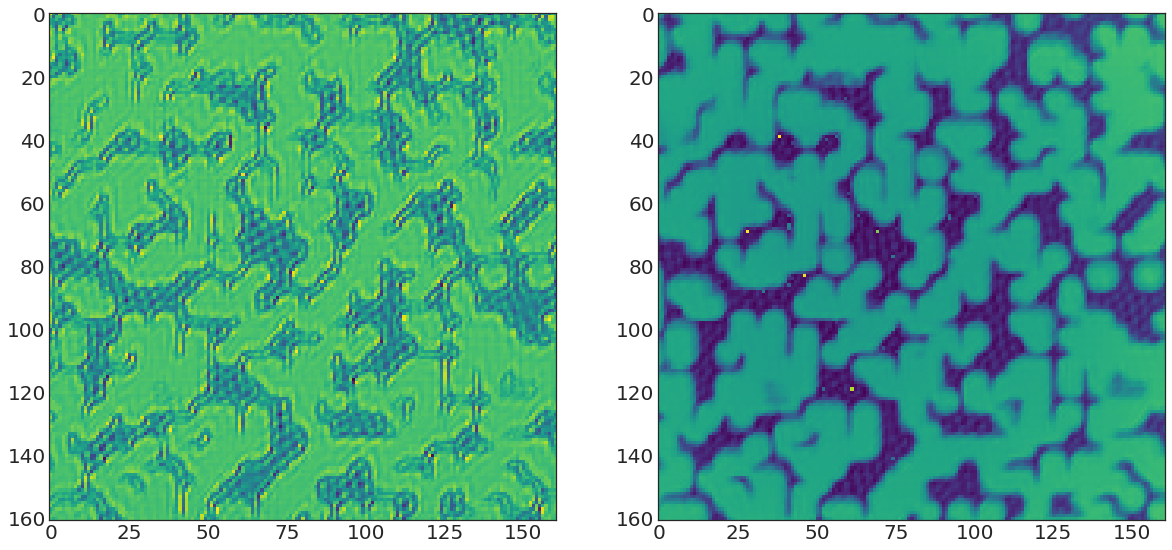

In [9]:
fig,ax = plt.subplots(1,2,figsize=(20,10))
ax[0].imshow(amp[:,:,32,32])
ax[1].imshow(ph[:,:,32,32])

In [10]:
tst_strt = amp.shape[0]-NLTEST #Where to index from
print(tst_strt)

X_train = data_diffr_red[:NLINES,:].reshape(-1,H,W)[:,np.newaxis,:,:]
X_test = data_diffr_red[tst_strt:,tst_strt:].reshape(-1,H,W)[:,np.newaxis,:,:]
Y_I_train = amp[:NLINES,:].reshape(-1,H,W)[:,np.newaxis,:,:]
Y_I_test = amp[tst_strt:,tst_strt:].reshape(-1,H,W)[:,np.newaxis,:,:]
Y_phi_train = ph[:NLINES,:].reshape(-1,H,W)[:,np.newaxis,:,:]
Y_phi_test = ph[tst_strt:,tst_strt:].reshape(-1,H,W)[:,np.newaxis,:,:]

ntrain = X_train.shape[0]*X_train.shape[1]
ntest = X_test.shape[0]*X_test.shape[1]

print(X_train.shape, X_test.shape)

X_train, Y_I_train, Y_phi_train = shuffle(X_train, Y_I_train, Y_phi_train, random_state=0)

101
(16100, 1, 64, 64) (3600, 1, 64, 64)


In [11]:
#Training data
X_train_tensor = torch.Tensor(X_train) 
Y_I_train_tensor = torch.Tensor(Y_I_train) 
Y_phi_train_tensor = torch.Tensor(Y_phi_train)

#Test data
X_test_tensor = torch.Tensor(X_test) 
Y_I_test_tensor = torch.Tensor(Y_I_test) 
Y_phi_test_tensor = torch.Tensor(Y_phi_test)

print(Y_phi_train.max(), Y_phi_train.min())

print(X_train_tensor.shape, Y_I_train_tensor.shape, Y_phi_train_tensor.shape)

train_data = TensorDataset(X_train_tensor,Y_I_train_tensor,Y_phi_train_tensor)
test_data = TensorDataset(X_test_tensor)

3.1268637 -1.564053
torch.Size([16100, 1, 64, 64]) torch.Size([16100, 1, 64, 64]) torch.Size([16100, 1, 64, 64])


In [12]:
N_TRAIN = X_train_tensor.shape[0]
train_data2, valid_data = torch.utils.data.random_split(train_data,[N_TRAIN-N_VALID,N_VALID])
print(len(train_data2),len(valid_data),len(test_data))

15295 805 3600


In [13]:
#download and load training data
trainloader = DataLoader(train_data2, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

validloader = DataLoader(valid_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

#same for test
#download and load training data
testloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

In [42]:
nconv = 32


class recon_model(nn.Module):

  def __init__(self):
      super(recon_model, self).__init__()

      self.encoder = nn.Sequential( # Appears sequential has similar functionality as TF avoiding need for separate model definition and activ
        nn.Conv2d(in_channels=1, out_channels=nconv, kernel_size=3, stride=1, padding=(1,1)),
        nn.ReLU(),
        nn.Conv2d(nconv, nconv, 3, stride=1, padding=(1,1)),
        nn.ReLU(),
        nn.MaxPool2d((2,2)),

        nn.Conv2d(nconv, nconv*2, 3, stride=1, padding=(1,1)),
        nn.ReLU(),
        nn.Conv2d(nconv*2, nconv*2, 3, stride=1, padding=(1,1)),          
        nn.ReLU(),
        nn.MaxPool2d((2,2)),

        nn.Conv2d(nconv*2, nconv*4, 3, stride=1, padding=(1,1)),
        nn.ReLU(),
        nn.Conv2d(nconv*4, nconv*4, 3, stride=1, padding=(1,1)),          
        nn.ReLU(),
        nn.MaxPool2d((2,2)),
        )

      self.decoder1 = nn.Sequential(

        nn.Conv2d(nconv*4, nconv*4, 3, stride=1, padding=(1,1)),
        nn.ReLU(),
        nn.Conv2d(nconv*4, nconv*4, 3, stride=1, padding=(1,1)),
        nn.ReLU(),
        nn.Upsample(scale_factor=2, mode='bilinear'),

        nn.Conv2d(nconv*4, nconv*2, 3, stride=1, padding=(1,1)),
        nn.ReLU(),
        nn.Conv2d(nconv*2, nconv*2, 3, stride=1, padding=(1,1)),
        nn.ReLU(),
        nn.Upsample(scale_factor=2, mode='bilinear'),
          
        nn.Conv2d(nconv*2, nconv*2, 3, stride=1, padding=(1,1)),
        nn.ReLU(),
        nn.Conv2d(nconv*2, nconv*2, 3, stride=1, padding=(1,1)),
        nn.ReLU(),
        nn.Upsample(scale_factor=2, mode='bilinear'),

        nn.Conv2d(nconv*2, 1, 3, stride=1, padding=(1,1)),
        nn.Sigmoid() #Amplitude model
        )

      self.decoder2 = nn.Sequential(

        nn.Conv2d(nconv*4, nconv*4, 3, stride=1, padding=(1,1)),
        nn.ReLU(),
        nn.Conv2d(nconv*4, nconv*4, 3, stride=1, padding=(1,1)),
        nn.ReLU(),
        nn.Upsample(scale_factor=2, mode='bilinear'),

        nn.Conv2d(nconv*4, nconv*2, 3, stride=1, padding=(1,1)),
        nn.ReLU(),
        nn.Conv2d(nconv*2, nconv*2, 3, stride=1, padding=(1,1)),
        nn.ReLU(),
        nn.Upsample(scale_factor=2, mode='bilinear'),
          
        nn.Conv2d(nconv*2, nconv*2, 3, stride=1, padding=(1,1)),
        nn.ReLU(),
        nn.Conv2d(nconv*2, nconv*2, 3, stride=1, padding=(1,1)),
        nn.ReLU(),
        nn.Upsample(scale_factor=2, mode='bilinear'),

        nn.Conv2d(nconv*2, 1, 3, stride=1, padding=(1,1)),
        nn.Tanh() #Phase model
        )
  
  def forward(self,x):
      x1 = self.encoder(x)
      amp = self.decoder1(x1)
      ph = self.decoder2(x1)

      #Restore -pi to pi range
      ph = ph*np.pi #Using tanh activation (-1 to 1) for phase so multiply by pi

      return amp,ph
      

  


In [43]:
model = recon_model()
for ft_images,amps,phs in trainloader:
    print("batch size:", ft_images.shape)
    amp, ph = model(ft_images)
    print(amp.shape, ph.shape)
    print(amp.dtype, ph.dtype)
    break

batch size: torch.Size([512, 1, 64, 64])
torch.Size([512, 1, 64, 64]) torch.Size([512, 1, 64, 64])
torch.float32 torch.float32


In [67]:

class LitPtychoNN(pl.LightningModule):
  def __init__(self, model):
    super().__init__()
    self.model = model()
    self.criterion = nn.L1Loss()
    self.lr = LR


  def configure_optimizers(self):
    iterations_per_epoch = np.floor((N_TRAIN-N_VALID)/BATCH_SIZE)+1 #Final batch will be less than batch size
    step_size = 6*iterations_per_epoch #Paper recommends 2-10 number of iterations, step_size is half cycle
    print("LR step size is:", step_size, "which is every %d epochs" %(step_size/iterations_per_epoch))

    optimizer = torch.optim.Adam(self.model.parameters(), lr = self.lr)
    scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=LR/10, max_lr=LR, step_size_up=step_size,
                                                  cycle_momentum=False, mode='triangular2')
    return optimizer#, [scheduler]


  def training_step(self, train_batch, batch_idx):

    ft_images, amps, phs = train_batch

    pred_amps, pred_phs = self.model(ft_images) #Forward pass

    #Compute losses
    loss_a = self.criterion(pred_amps,amps) #Monitor amplitude loss
    loss_p = self.criterion(pred_phs,phs) #Monitor phase loss but only within support (which may not be same as true amp)
    loss = loss_a + loss_p #Use equiweighted amps and phase

    self.log("total_loss", loss, on_step = False, on_epoch=True, prog_bar=True)
    self.log("amp_loss", loss_a, on_step = False, on_epoch=True, prog_bar=True),
    self.log("ph_loss", loss_p, on_step = False, on_epoch=True, prog_bar=True)

    return loss
    

  def validation_step (self, val_batch, batch_idx):

    ft_images, amps, phs = val_batch

    pred_amps, pred_phs = self.model(ft_images) #Forward pass
    
    val_loss_a = self.criterion(pred_amps,amps) 
    val_loss_p = self.criterion(pred_phs,phs)
    val_loss = val_loss_a + val_loss_p


    self.log("total_val_loss", val_loss, on_step = False, on_epoch=True, prog_bar=True)
    self.log("amp__val_loss", val_loss_a, on_step = False, on_epoch=True, prog_bar=True)
    self.log("ph_val_loss", val_loss_p, on_step = False, on_epoch=True, prog_bar=True)



In [68]:
# train the model (hint: here are some helpful Trainer arguments for rapid idea iteration)
model = LitPtychoNN(recon_model)

lr_monitor = LearningRateMonitor(logging_interval='step')
checkpoint_callback = ModelCheckpoint(monitor='total_val_loss',
    dirpath='trained_model',
    filename='{epoch}'
    )

trainer = pl.Trainer(gpus = 2, max_epochs=12, 
                    callbacks=[lr_monitor, checkpoint_callback],
                    auto_lr_find = True, 
                    strategy = 'dp')

lr_finder = trainer.tune(model, trainloader, validloader)
fig = lr_finder.plot(suggest=True)
fig.show()



GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


LR step size is: 180.0 which is every 6 epochs


/home/mcherukara/miniconda3/envs/PyTorch1.11/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:487: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(
/home/mcherukara/miniconda3/envs/PyTorch1.11/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1927: PossibleUserWarning: The number of training batches (30) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(
Finding best initial lr: 100%|██████████| 100/100 [00:09<00:00,  9.40it/s]Restoring states from the checkpoint path at /lcrc/project/AICDI/PtychoNN/PyTorch/PyTorch_lightning/.lr_find_31f4843a-e266-4a44-83d3-cf0781ea162a.ckpt
/home/mcherukara/miniconda3/envs/PyTorch1.11/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:17

AttributeError: 'dict' object has no attribute 'plot'

In [61]:
trainer.fit(model, trainloader, validloader)

/home/mcherukara/miniconda3/envs/PyTorch1.11/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:611: UserWarning: Checkpoint directory /lcrc/project/AICDI/PtychoNN/PyTorch/PyTorch_lightning/trained_model exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name      | Type        | Params
------------------------------------------
0 | model     | recon_model | 1.2 M 
1 | criterion | L1Loss      | 0     
------------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.988     Total estimated model params size (MB)
/home/mcherukara/miniconda3/envs/PyTorch1.11/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1927: PossibleUserWarning: The number of training batches (30) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if y

LR step size is: 180.0 which is every 6 epochs
Epoch 11: 100%|██████████| 32/32 [00:03<00:00,  9.82it/s, loss=nan, v_num=33632, total_val_loss=nan.0, amp__val_loss=nan.0, ph_val_loss=nan.0, total_loss=nan.0, amp_loss=nan.0, ph_loss=nan.0]  


In [46]:
batches = np.linspace(0,len(metrics['lrs']),len(metrics['lrs'])+1)
epoch_list = batches/iterations_per_epoch

plt.plot(epoch_list[1:],metrics['lrs'], 'C3-')
plt.grid()
plt.ylabel("Learning rate")
plt.xlabel("Epoch")

NameError: name 'metrics' is not defined

In [38]:
losses_arr = np.array(metrics['losses'])
val_losses_arr = np.array(metrics['val_losses'])
losses_arr.shape
fig, ax = plt.subplots(3,sharex=True, figsize=(15, 8))
ax[0].plot(losses_arr[:,0], 'C3o-', label = "Total Train loss")
ax[0].plot(val_losses_arr[:,0], 'C0o-', label = "Total Val loss")
ax[0].set(ylabel='Loss')
ax[0].grid()
ax[0].legend(loc='center right', bbox_to_anchor=(1.5, 0.5))
ax[1].plot(losses_arr[:,1], 'C3o-', label = "Train Amp loss")
ax[1].plot(val_losses_arr[:,1], 'C0o-', label = "Val Amp loss")
ax[1].set(ylabel='Loss')
ax[1].grid()
ax[1].legend(loc='center right', bbox_to_anchor=(1.5, 0.5))
ax[2].plot(losses_arr[:,2], 'C3o-', label = "Train Ph loss")
ax[2].plot(val_losses_arr[:,2], 'C0o-', label = "Val Ph loss")
ax[2].set(ylabel='Loss')
ax[2].grid()
ax[2].legend(loc='center right', bbox_to_anchor=(1.5, 0.5))

plt.tight_layout()
plt.xlabel("Epochs")

NameError: name 'metrics' is not defined

In [62]:
best_model_path = checkpoint_callback.best_model_path
print("Best model at", best_model_path)
best_lit_model = LitPtychoNN.load_from_checkpoint(best_model_path, model=recon_model)
best_model = best_lit_model.model
best_model.eval() #imp when have dropout etc
amps = []
phs = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
best_model = best_model.to(device)
for i, ft_images in enumerate(testloader):
    ft_images = ft_images[0].to(device)
    amp, ph = best_model(ft_images)
    for j in range(ft_images.shape[0]):
        amps.append(amp[j].detach().to("cpu").numpy())
        phs.append(ph[j].detach().to("cpu").numpy())

Best model at /lcrc/project/AICDI/PtychoNN/PyTorch/PyTorch_lightning/trained_model/epoch=1-v1.ckpt


In [63]:
amps = np.array(amps).squeeze()
phs = np.array(phs).squeeze()
print(amps.shape, amps.dtype)
print(phs.shape, phs.dtype)

(3600, 64, 64) float32
(3600, 64, 64) float32


<Figure size 432x288 with 0 Axes>

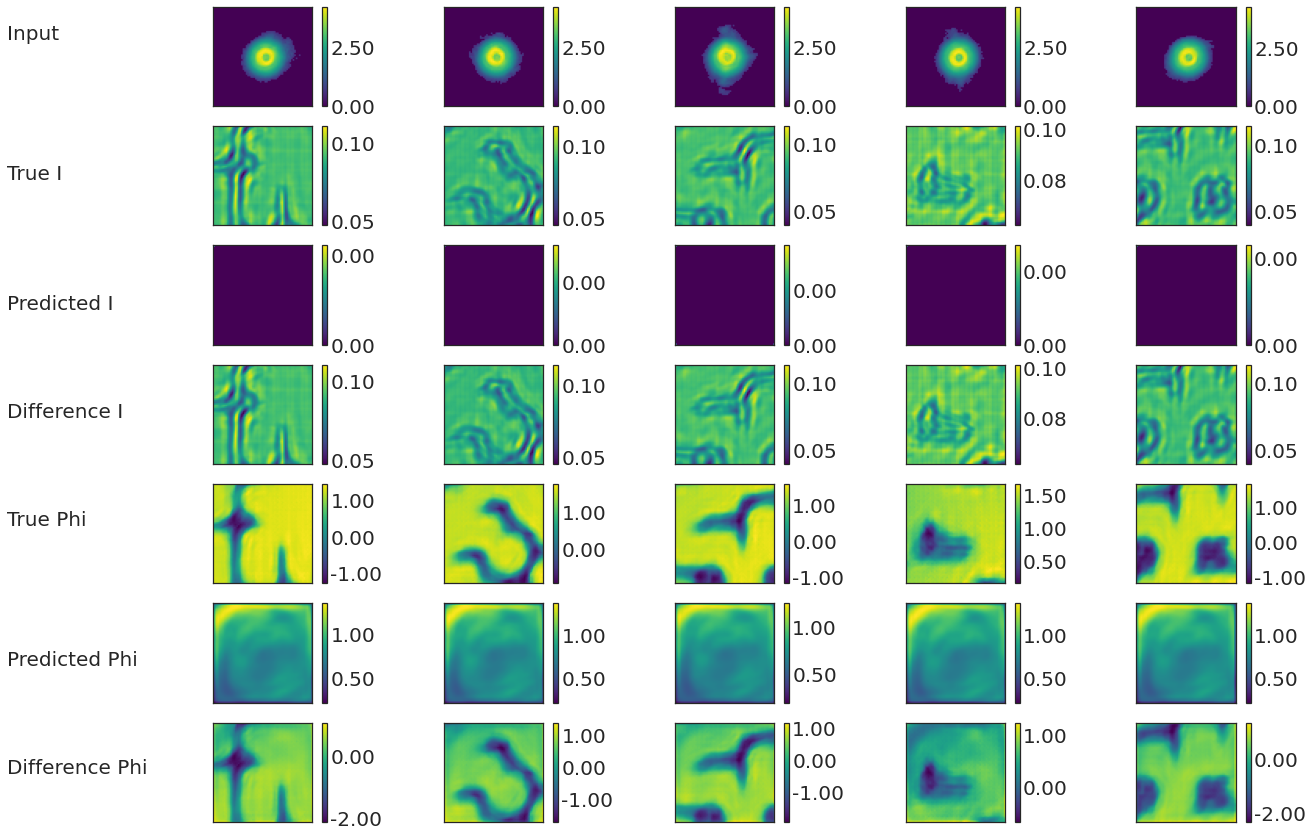

In [64]:
h,w = 64,64
ntest=amps.shape[0]
plt.viridis()
n = 5
f,ax=plt.subplots(7,n,figsize=(20, 15))
plt.gcf().text(0.02, 0.85, "Input", fontsize=20)
plt.gcf().text(0.02, 0.72, "True I", fontsize=20)
plt.gcf().text(0.02, 0.6, "Predicted I", fontsize=20)
plt.gcf().text(0.02, 0.5, "Difference I", fontsize=20)
plt.gcf().text(0.02, 0.4, "True Phi", fontsize=20)
plt.gcf().text(0.02, 0.27, "Predicted Phi", fontsize=20)
plt.gcf().text(0.02, 0.17, "Difference Phi", fontsize=20)

for i in range(0,n):
    j=int(round(np.random.rand()*ntest))

        # display FT
    im=ax[0,i].imshow(np.log10(X_test[j].reshape(h, w)+1))
    plt.colorbar(im, ax=ax[0,i], format='%.2f')
    ax[0,i].get_xaxis().set_visible(False)
    ax[0,i].get_yaxis().set_visible(False)

    # display original intens
    im=ax[1,i].imshow(Y_I_test[j].reshape(h, w))
    plt.colorbar(im, ax=ax[1,i], format='%.2f')
    ax[1,i].get_xaxis().set_visible(False)
    ax[1,i].get_yaxis().set_visible(False)
    
    # display predicted intens
    im=ax[2,i].imshow(amps[j].reshape(h, w))
    plt.colorbar(im, ax=ax[2,i], format='%.2f')
    ax[2,i].get_xaxis().set_visible(False)
    ax[2,i].get_yaxis().set_visible(False)
    
        # display original phase
    im=ax[4,i].imshow(Y_phi_test[j].reshape(h, w))
    plt.colorbar(im, ax=ax[4,i], format='%.2f')
    ax[4,i].get_xaxis().set_visible(False)
    ax[4,i].get_yaxis().set_visible(False)
    
    # display predicted phase
    im=ax[5,i].imshow(phs[j].reshape(h, w))
    plt.colorbar(im, ax=ax[5,i], format='%.2f')
    ax[5,i].get_xaxis().set_visible(False)
    ax[5,i].get_yaxis().set_visible(False)
    
    #Difference in amplitude
    im=ax[3,i].imshow(Y_I_test[j].reshape(h, w)-amps[j].reshape(h, w))
    plt.colorbar(im, ax=ax[3,i], format='%.2f')
    ax[3,i].get_xaxis().set_visible(False)
    ax[3,i].get_yaxis().set_visible(False)
    
    # Difference in phase
    im=ax[6,i].imshow(Y_phi_test[j].reshape(h, w)-phs[j].reshape(h, w))
    plt.colorbar(im, ax=ax[6,i], format='%.2f')
    ax[6,i].get_xaxis().set_visible(False)
    ax[6,i].get_yaxis().set_visible(False)
    
plt.show()

In [22]:
point_size = 3
overlap = 4*point_size

In [23]:
tst_side = 60

composite_amp = np.zeros((tst_side*point_size+overlap,tst_side*point_size+overlap),float)
ctr = np.zeros_like(composite_amp)
data_reshaped = amps.reshape(tst_side,tst_side,64,64)[:,:,32-int(overlap/2):32+int(overlap/2),
                                                     32-int(overlap/2):32+int(overlap/2)]

for i in range(tst_side):
    for j in range(tst_side):
        composite_amp[point_size*i:point_size*i+overlap, point_size*j:point_size*j+overlap] += data_reshaped[i,j]
        ctr[point_size*i:point_size*i+overlap, point_size*j:point_size*j+overlap] +=1

In [24]:

composite_phase = np.zeros((tst_side*point_size+overlap,tst_side*point_size+overlap),float)
ctr = np.zeros_like(composite_phase)
data_reshaped = phs.reshape(tst_side,tst_side,64,64)[:,:,32-int(overlap/2):32+int(overlap/2),
                                                     32-int(overlap/2):32+int(overlap/2)]

for i in range(tst_side):
    for j in range(tst_side):
        composite_phase[point_size*i:point_size*i+overlap, point_size*j:point_size*j+overlap] += data_reshaped[i,j]
        ctr[point_size*i:point_size*i+overlap, point_size*j:point_size*j+overlap] +=1

In [25]:
stitched_phase = composite_phase[int(overlap/2):-int(overlap/2), int(overlap/2):-int(overlap/2)]/ctr[int(overlap/2)
                                                                    :-int(overlap/2), int(overlap/2):-int(overlap/2)]

stitched_amp = composite_amp[int(overlap/2):-int(overlap/2), int(overlap/2):-int(overlap/2)]/ctr[int(overlap/2)
                                                                    :-int(overlap/2), int(overlap/2):-int(overlap/2)]

stitched_amp_down = resize(stitched_amp, (60,60), preserve_range=True, anti_aliasing=True)
stitched_phase_down = resize(stitched_phase, (60,60), preserve_range=True, anti_aliasing=True)

In [26]:
true_amp = Y_I_test.reshape(NLTEST,NLTEST,64,64)
true_ph = Y_phi_test.reshape(NLTEST,NLTEST,64,64)

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


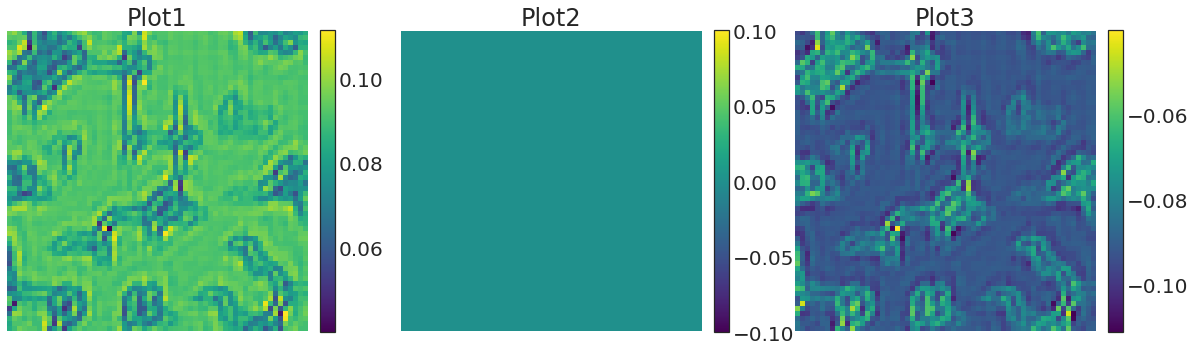

In [27]:
plot3([true_amp[:,:,32,32],stitched_amp_down,stitched_amp_down-true_amp[:,:,32,32]],[])

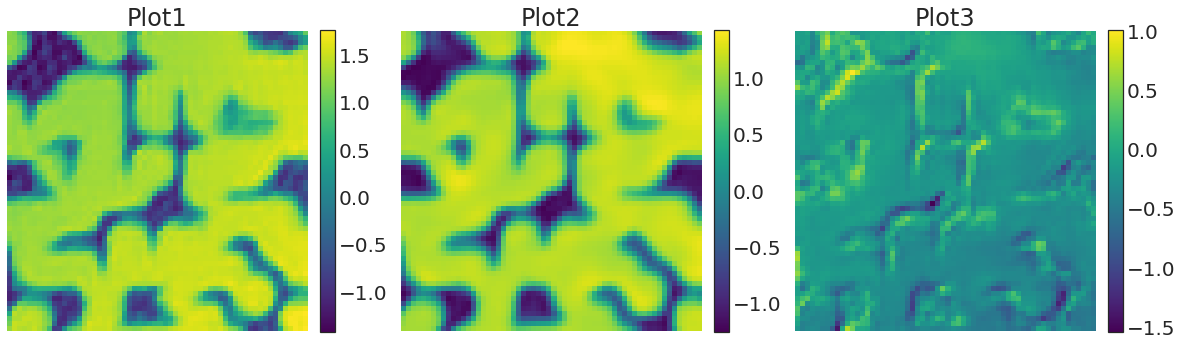

In [28]:
plot3([true_ph[:,:,32,32],stitched_phase_down,stitched_phase_down-true_ph[:,:,32,32]],[])

In [29]:
from sklearn.metrics import mean_squared_error as mse
print ("MSE in amplitude: ", mse(stitched_amp_down, true_amp[:,:,32,32]))
print ("MSE in phase: ", mse(stitched_phase_down, true_ph[:,:,32,32]))

MSE in amplitude:  0.007799001918987843
MSE in phase:  0.09935621425532791
